# Fluorescence intensity detection and identification system

Using OpenCV to detect fluorescence intensity which emulates SYBR Green fluorescence from multiple color jpeg images. Data is parsed from HTTP POST requests by ESP32-CAM with OV2640 sensor.

In [1]:
# import os
# os.environ['QT_QPA_PLATFORM'] = 'xcb'

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## 1. Test camera noise by getting average pixel value of a blank image

Get image from box_wb_off

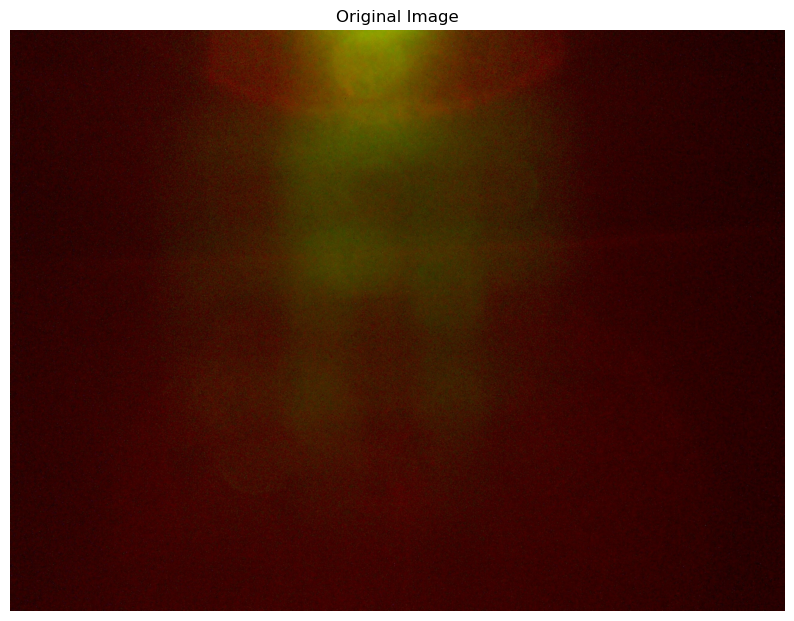

In [ ]:
img = cv.imread('../AwbFluo2/img_full_bg.jpg')
gray1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

# plt.figure(figsize=(10, 8))
# plt.imshow(gray1, cmap='gray')
# plt.title('Grayscale Image')
# plt.axis('off')
# plt.show()

Average all pixels in the image and print out the 8-bit value.

Overall average pixel value: 15.89

Image dimensions: 2592 x 1944
Section size: 648 x 648
\Sectioned image analysis:
Min section average: 6.16
Max section average: 42.85
Standard deviation across sections: 11.28


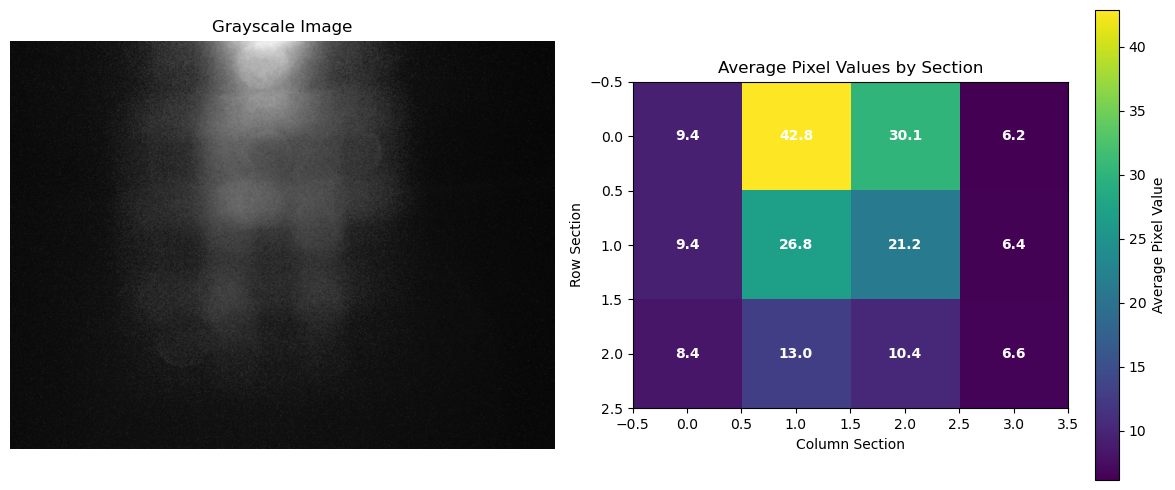

In [83]:
# Convert to grayscale for noise analysis
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def pixel_average_analysis(gray, section_rows=3, section_cols=4, verbose=True):
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    # Divide image into sections
    height, width = gray.shape
    section_rows = section_rows
    section_cols = section_cols

    row_size = height // section_rows
    col_size = width // section_cols

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"Section size: {col_size} x {row_size}")
    # print("\nAverage pixel values by section:")

    # Create a matrix to store section averages
    section_averages = np.zeros((section_rows, section_cols))

    for i in range(section_rows):
        for j in range(section_cols):
            # Calculate section boundaries
            start_row = i * row_size
            end_row = (i + 1) * row_size if i < section_rows - 1 else height
            start_col = j * col_size
            end_col = (j + 1) * col_size if j < section_cols - 1 else width
            
            # Extract section
            section = gray[start_row:end_row, start_col:end_col]
            
            # Calculate average for this section
            section_avg = np.mean(section)
            section_averages[i, j] = section_avg
            
            # print(f"Section [{i+1},{j+1}]: {section_avg:.2f}")

    # Display statistics
    if verbose:
        print(f"\Sectioned image analysis:")
        print(f"Min section average: {np.min(section_averages):.2f}")
        print(f"Max section average: {np.max(section_averages):.2f}")
        print(f"Standard deviation across sections: {np.std(section_averages):.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(section_averages, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Values by Section')
        plt.colorbar(label='Average Pixel Value')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        for i in range(section_rows):
            for j in range(section_cols):
                plt.text(j, i, f'{section_averages[i,j]:.1f}', 
                        ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, np.max(section_averages), np.min(section_averages)

avgg, maxg, _ = pixel_average_analysis(gray, section_rows=3, section_cols=4)


Image has background noise. Background will be subtracted from fluorescence image.

In [84]:
background_model = gray.copy().astype(np.float32)

def subtract_background(image, background):
    # Ensure both are float32 for proper subtraction
    img_float = image.astype(np.float32)
    bg_float = background.astype(np.float32)
    
    # Subtract background and clip to valid range
    result = np.clip(img_float - bg_float, 0, 255)
    return result.astype(np.uint8)

## 2. Image segmentation to focus on ROI

Overall average pixel value: 12.38

Image dimensions: 2592 x 1944
Section size: 648 x 648
\Sectioned image analysis:
Min section average: 1.42
Max section average: 53.49
Standard deviation across sections: 18.10


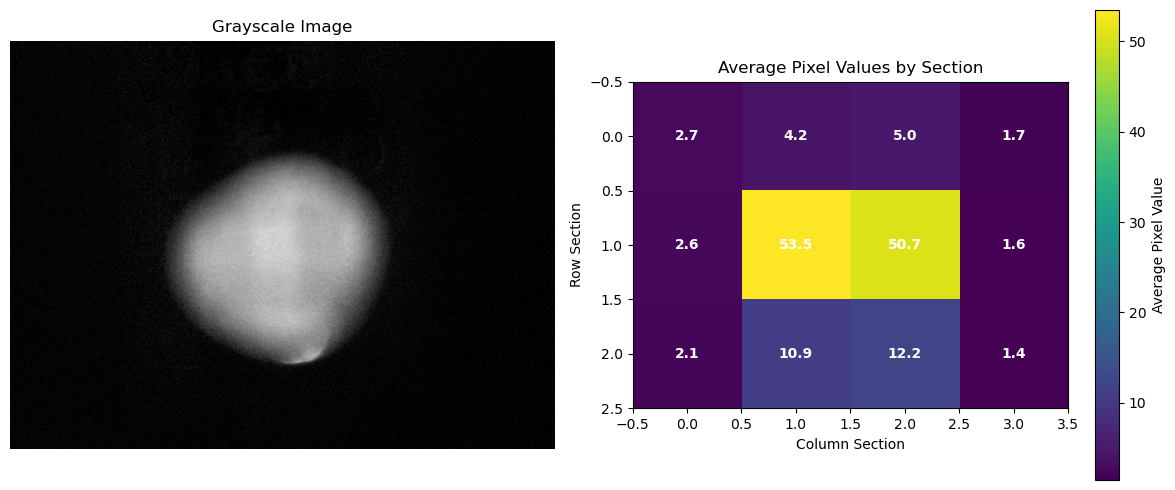

(np.float64(12.382861320682823),
 np.float64(53.48520614235635),
 np.float64(1.4224941891479956))

In [ ]:
fluo = cv.imread('../AwbFluo2/img_full_0000.jpg')
fluog = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)

suback_fluog = subtract_background(fluog, background_model)
pixel_average_analysis(suback_fluog, section_rows=3, section_cols=4)

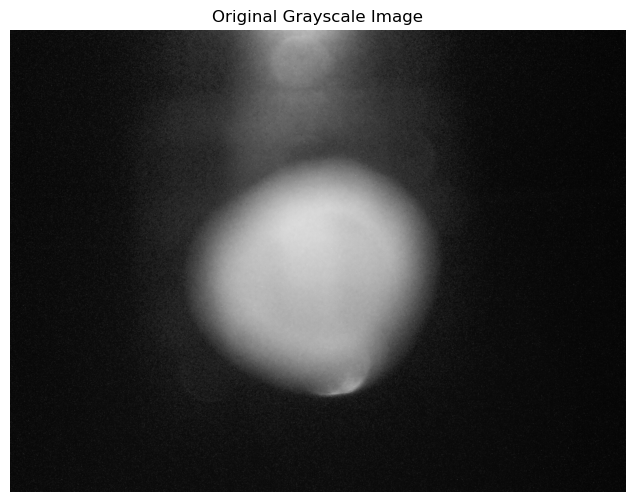

In [86]:
plt.figure(figsize=(8, 6))
plt.imshow(fluog, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

In [87]:
def get_roi(fluo, suback_fluog, threshold_value=8, verbose=True):
    # Pixels brighter than 8 will become white (255), others black (0).
    threshold_value = threshold_value
    _, mask = cv.threshold(suback_fluog, threshold_value, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour by area
        largest_contour = max(contours, key=cv.contourArea)

        x, y, w, h = cv.boundingRect(largest_contour)
        cv.rectangle(fluo, (x, y), (x+w, y+h), (0, 0, 255), 2)

        if verbose:
            print(f"Found object with bounding box: x={x}, y={y}, width={w}, height={h}")
    else:
        if verbose:
            print("No object found meeting the threshold criteria.")

    if verbose:
        plt.figure(figsize=(15, 5))

        # Original image with ROI marked
        plt.subplot(1, 3, 1)
        plt.imshow(cv.cvtColor(fluo, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title('Original Image with ROI Marked')
        plt.axis('off')

        # Grayscale image
        plt.subplot(1, 3, 2)
        plt.imshow(suback_fluog, cmap='gray')
        plt.title('Subtracted Grayscale Image')
        plt.axis('off')

        # Mask from thresholding
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask from Thresholding')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return x, y, w, h


Found object with bounding box: x=708, y=514, width=1127, height=1046


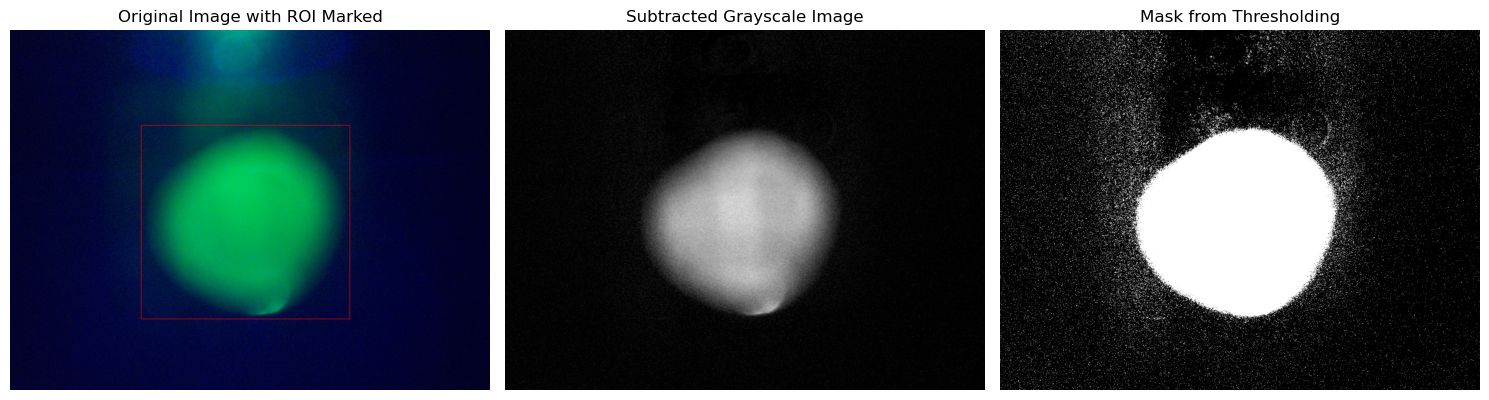

In [88]:

x, y, w, h = get_roi(fluo, suback_fluog)


Overall average pixel value: 12.38

Image dimensions: 2592 x 1944
ROI area: Row: 708:1835, Column: 514:1560
ROI size: 1127 x 1046
\Pixel analysis:
Average pixel value at ROI: 64.80
Standard deviation at ROI: 27.12


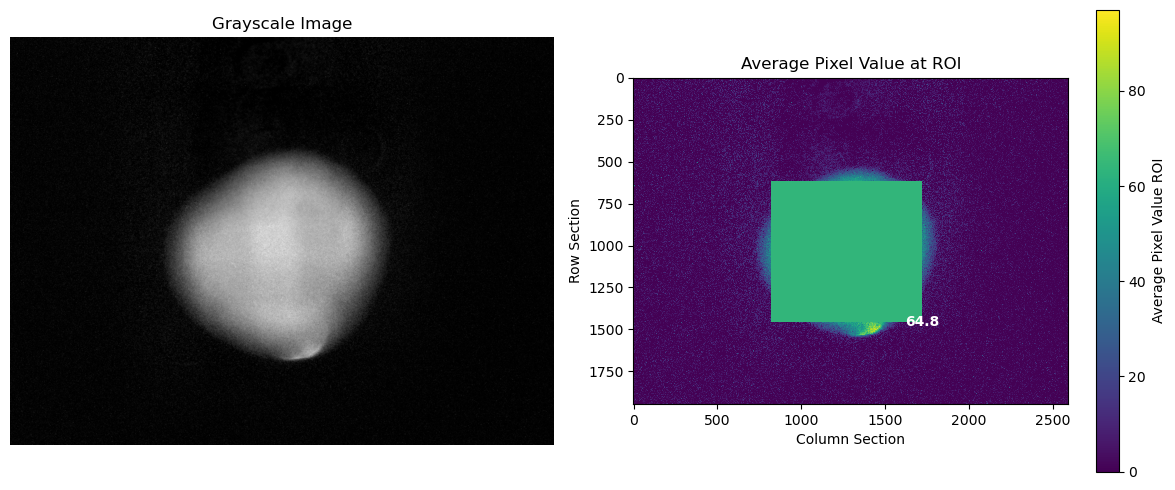

In [89]:
# Use a separate pixel analysis function for ROI images

def pixel_roi_analysis(gray, x, y, w, h, subset=1.0, verbose=True):
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    height, width = gray.shape

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"ROI area: Row: {x}:{x+w}, Column: {y}:{y+h}")
        print(f"ROI size: {w} x {h}")

    # Subset dictates percentage of innermost ROI pixels
    subset = subset     # Value between 0 and 1 (fraction of ROI pixels)
    if subset == 1:
        x = x
        y = y
        w = w
        h = h    
    else:
        half_w = w // 2
        add_x = int(half_w * (1 - subset))
        x = x + add_x
        w = int(w * subset)

        half_h = h // 2
        add_y = int(half_h * (1 - subset))
        y = y + add_y
        h = int(h * subset)

    roi_section = gray[y:y+h, x:x+w]
    average_at_roi = np.mean(roi_section)
    std_dev_at_roi = np.std(roi_section)
            
    # Get image with ROI pixels replaced with average
    gray_avg_roi = gray.copy()
    for i in range(y, y + h):
        for j in range(x, x + w):
            gray_avg_roi[i, j] = average_at_roi

    # Display statistics
    if verbose:
        print(f"\Pixel analysis:")
        print(f"Average pixel value at ROI: {average_at_roi:.2f}")
        print(f"Standard deviation at ROI: {std_dev_at_roi:.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gray_avg_roi, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Value at ROI')
        plt.colorbar(label='Average Pixel Value ROI')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        plt.text(j, i, f'{average_at_roi:.1f}', ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, average_at_roi

overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.8)

Get average pixel value at ROI

In [90]:
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

Overall average pixel value: 12.38
Average pixel value at ROI: 64.80


## 3. Test on all fluorescent images (manual ROI identification)

Check first image

Overall average pixel value: 12.38

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.25
Max section average: 85.82
Standard deviation across sections: 22.35


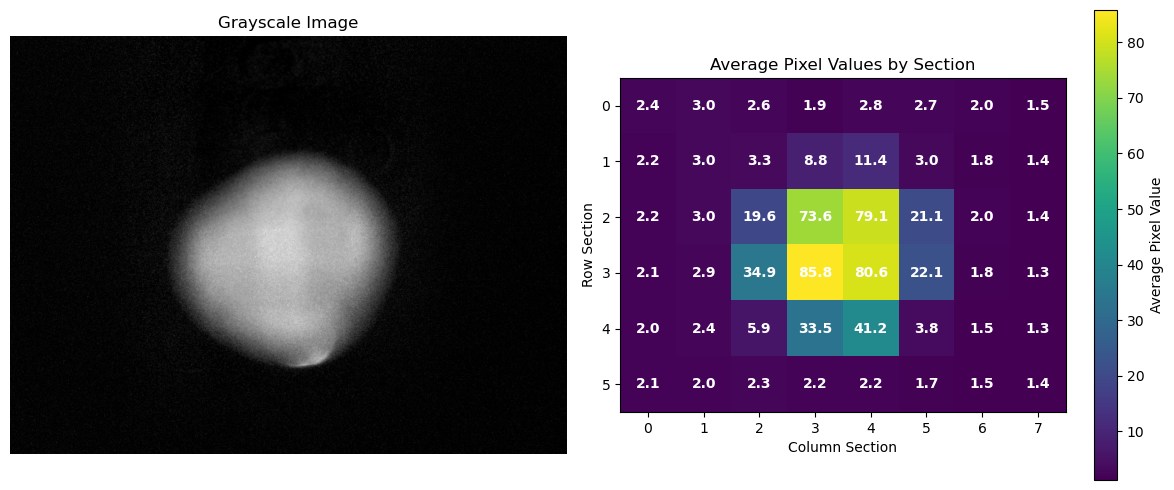

In [ ]:
fluo1 = cv.imread('../AwbFluo2/img_full_0000.jpg')
fluo1g = cv.cvtColor(fluo1, cv.COLOR_BGR2GRAY)
suback_fluog1 = subtract_background(fluo1g, background_model)
avg1g, max1g, _ = pixel_average_analysis(suback_fluog1, section_rows=6, section_cols=8)

In [92]:
print(f"Average: {avg1g} \nMax: {max1g}")

Average: 12.382861320682823 
Max: 85.81633897271757


Use on last image

Overall average pixel value: 3.82

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.52
Max section average: 11.46
Standard deviation across sections: 1.83


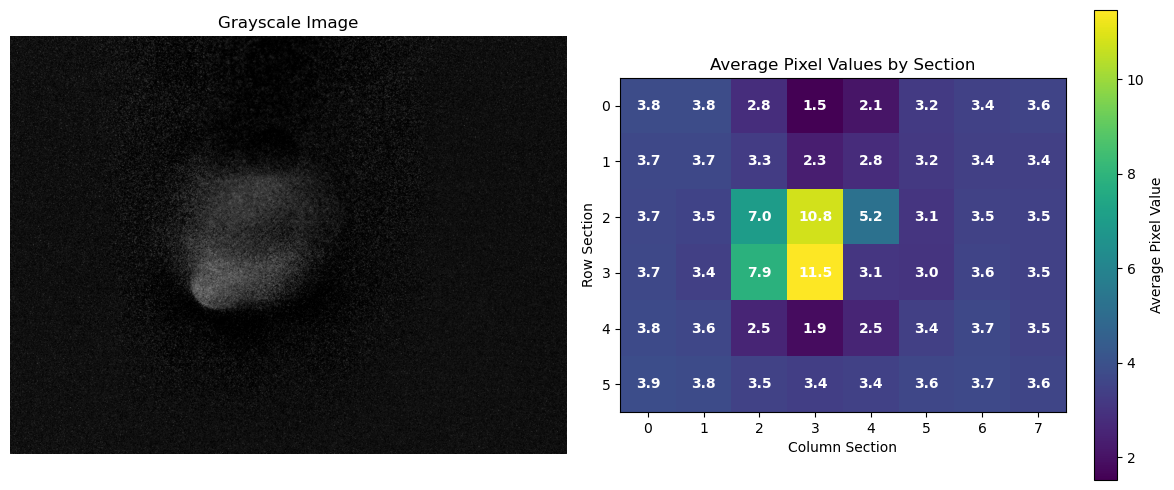

In [ ]:
fluo5 = cv.imread('../AwbFluo2/img_full_0005.jpg')
fluo5g = cv.cvtColor(fluo5, cv.COLOR_BGR2GRAY)
suback_fluog5 = subtract_background(fluo5g, background_model)
avg5g, max5g, _ = pixel_average_analysis(suback_fluog5, section_rows=6, section_cols=8)

Perform on all images

In [ ]:
max_list = np.zeros(6)

for i in range(0, 6):
    fluo = cv.imread(f'../AwbFluo2/img_full_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    suback_fluog = subtract_background(fluo_g, background_model)
    avg, max_val, min_val = pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8, verbose=False)
    print(f"Image {i}: Average: {avg:.2f}, Max: {max_val:.2f}, Min: {min_val:.2f}")
    
    max_list[i] = max_val

Image 0: Average: 12.38, Max: 85.82, Min: 1.25
Image 1: Average: 7.04, Max: 37.79, Min: 0.75
Image 2: Average: 5.31, Max: 25.71, Min: 1.31
Image 3: Average: 5.19, Max: 25.43, Min: 2.28
Image 4: Average: 4.95, Max: 21.31, Min: 2.44
Image 5: Average: 3.82, Max: 11.46, Min: 1.52


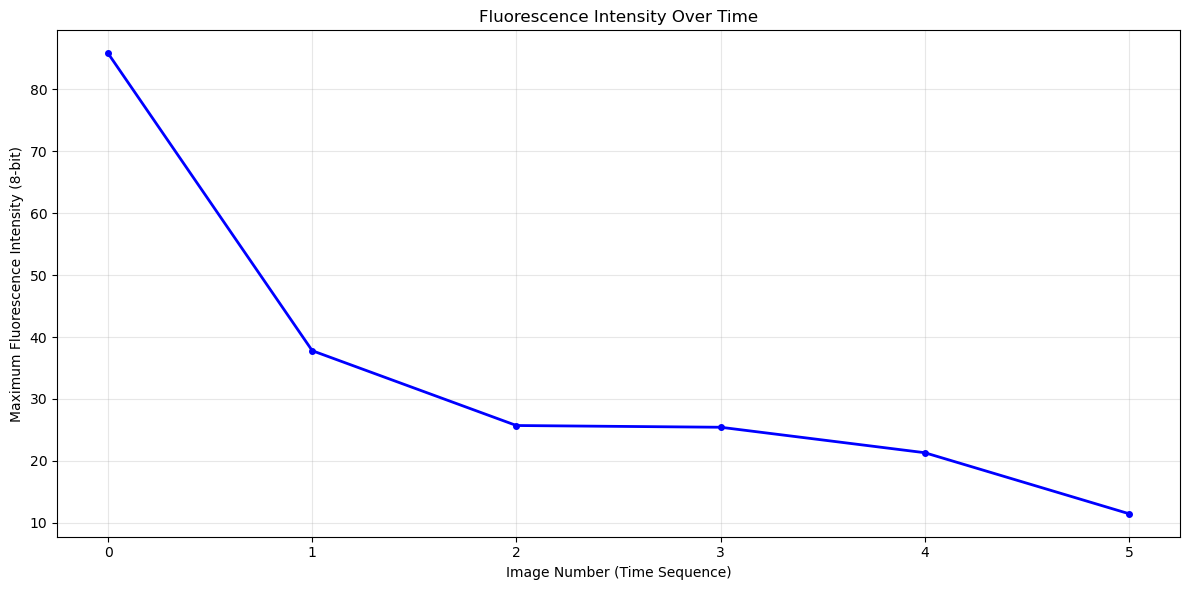

Min: 11.46
Max: 85.82
Range: 74.35


In [95]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(max_list)))

plt.plot(image_numbers, max_list, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

# mean_intensity = np.mean(max_list)
# std_intensity = np.std(max_list)
# plt.axhline(y=mean_intensity, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_intensity:.2f}')
# plt.axhline(y=mean_intensity + std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_intensity + std_intensity:.2f}')
# plt.axhline(y=mean_intensity - std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_intensity - std_intensity:.2f}')

# plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
# print(f"\nFluorescence Intensity Statistics:")
# print(f"Mean: {mean_intensity:.2f}")
# print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min: {min(max_list):.2f}")
print(f"Max: {max(max_list):.2f}")
print(f"Range: {max(max_list) - min(max_list):.2f}")

## 4. Test on all fluorescent images (with algorithmic ROI identification)

Found object with bounding box: x=708, y=514, width=1127, height=1046


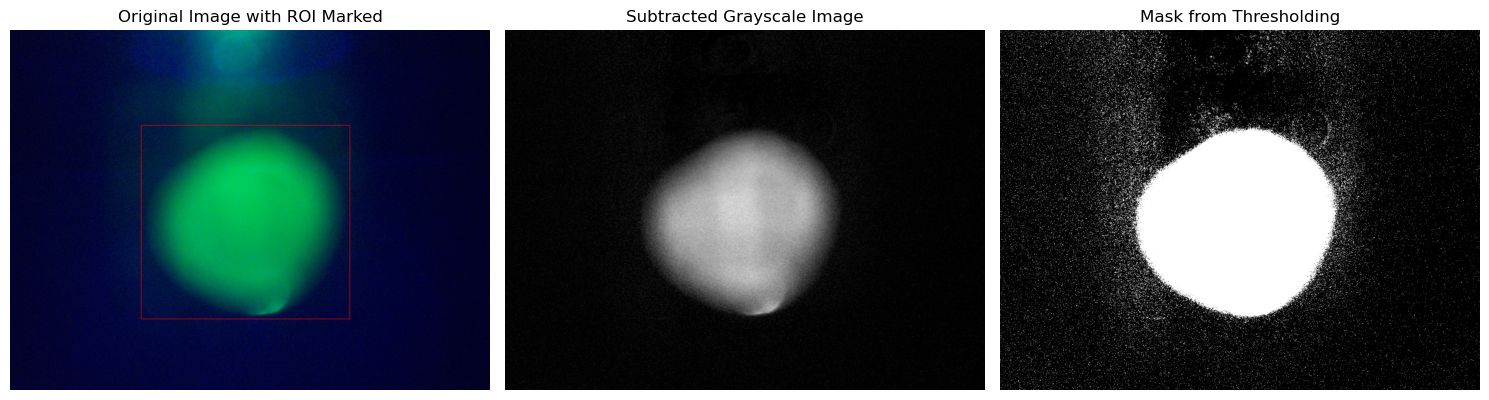

Overall average pixel value: 12.38

Image dimensions: 2592 x 1944
ROI area: Row: 708:1835, Column: 514:1560
ROI size: 1127 x 1046
\Pixel analysis:
Average pixel value at ROI: 88.74
Standard deviation at ROI: 7.65


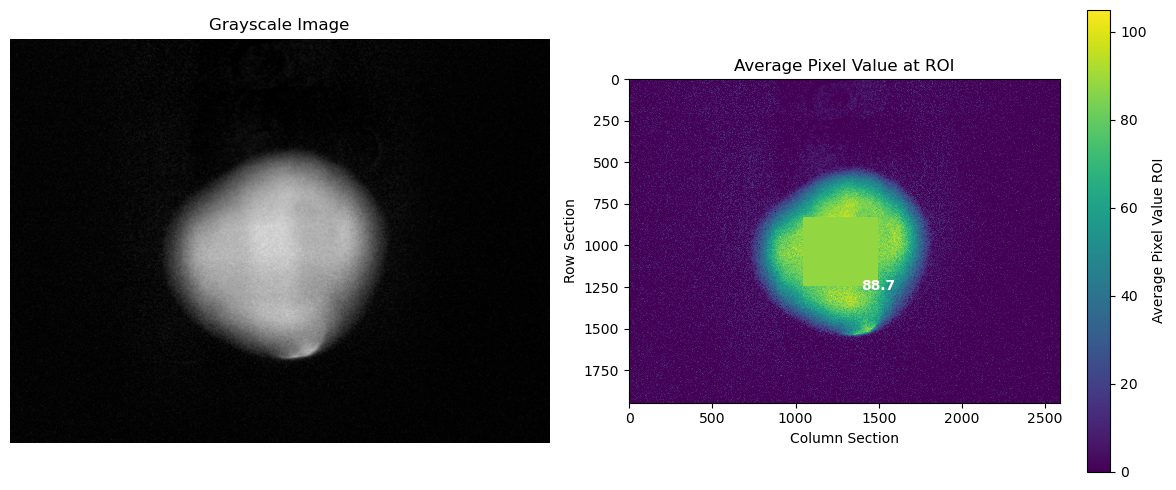

Overall average pixel value: 12.38
Average pixel value at ROI: 88.74


In [ ]:
fluo0 = cv.imread('../AwbFluo2/img_full_0000.jpg')
fluo0g = cv.cvtColor(fluo0, cv.COLOR_BGR2GRAY)
suback_fluog0 = subtract_background(fluo0g, background_model)

x, y, w, h = get_roi(fluo0, suback_fluog0, threshold_value=8, verbose=True)
overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog0, x, y, w, h, subset=0.4)
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

On last image

Found object with bounding box: x=783, y=613, width=628, height=661


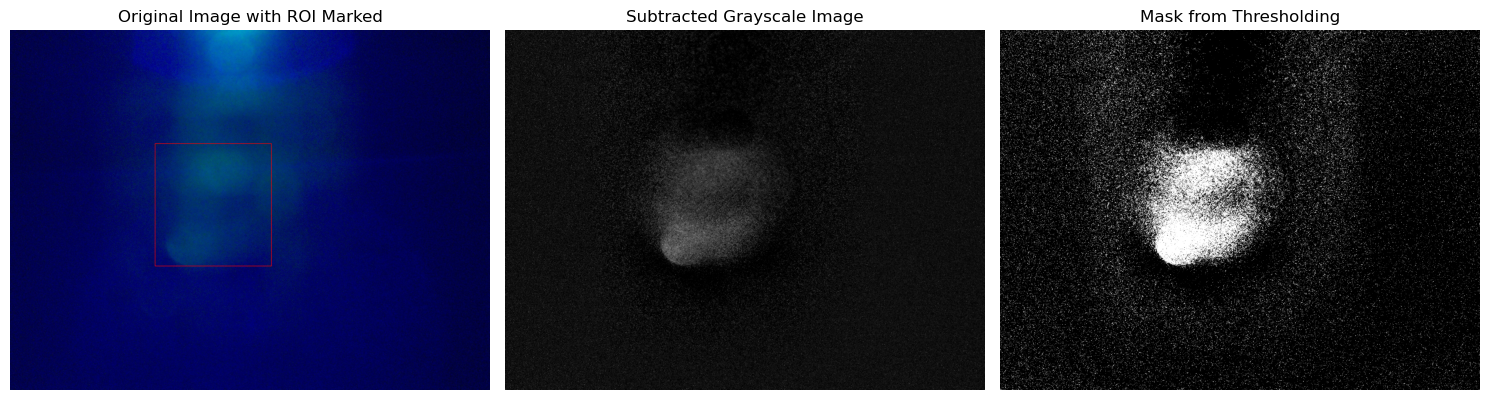

Overall average pixel value: 3.82

Image dimensions: 2592 x 1944
ROI area: Row: 783:1411, Column: 613:1274
ROI size: 628 x 661
\Pixel analysis:
Average pixel value at ROI: 11.52
Standard deviation at ROI: 4.75


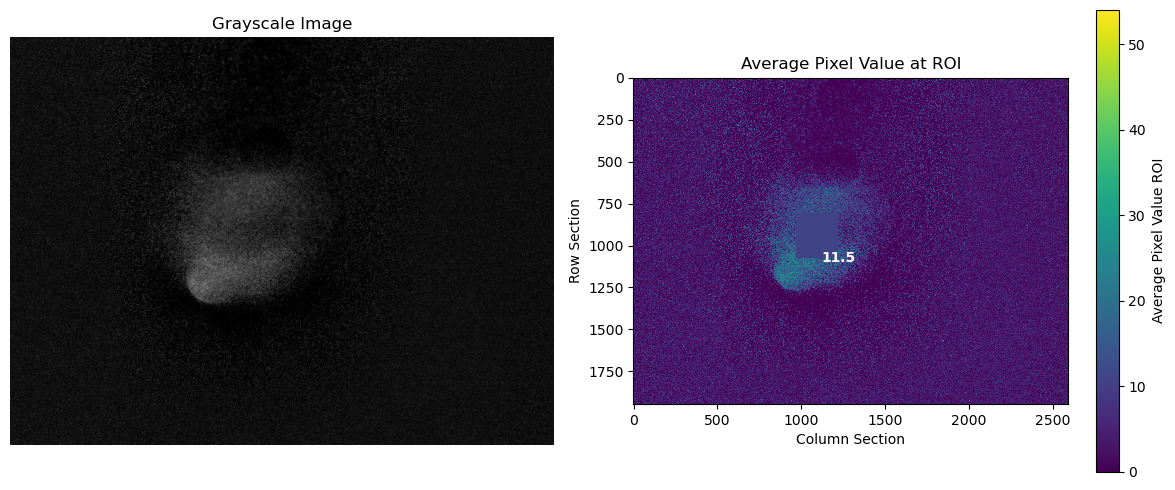

Overall average pixel value: 3.82
Average pixel value at ROI: 11.52


In [ ]:
fluo5 = cv.imread('../AwbFluo2/img_full_0005.jpg')
fluo5g = cv.cvtColor(fluo5, cv.COLOR_BGR2GRAY)
suback_fluog5 = subtract_background(fluo5g, background_model)
x5, y5, w5, h5 = get_roi(fluo5, suback_fluog5, threshold_value=8, verbose=True)
overall_avg5, average_at_roi5 = pixel_roi_analysis(suback_fluog5, x5, y5, w5, h5, subset=0.4)
print(f"Overall average pixel value: {overall_avg5:.2f}")
print(f"Average pixel value at ROI: {average_at_roi5:.2f}")

Perform on all images

In [ ]:
avg_roi_arr = np.zeros(6)

for i in range(0, 6):
    fluo = cv.imread(f'../AwbFluo2/img_full_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    suback_fluog = subtract_background(fluo_g, background_model)

    x, y, w, h = get_roi(fluo, suback_fluog, threshold_value=8, verbose=False)
    overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.1, verbose=False)
    print(f"Image {i}: Average: {overall_avg:.2f}, ROI average: {average_at_roi:.2f}")
    
    avg_roi_arr[i] = average_at_roi

Image 0: Average: 12.38, ROI average: 98.03
Image 1: Average: 7.04, ROI average: 39.76
Image 2: Average: 5.31, ROI average: 20.36
Image 3: Average: 5.19, ROI average: 18.84
Image 4: Average: 4.95, ROI average: 13.59
Image 5: Average: 3.82, ROI average: 10.39


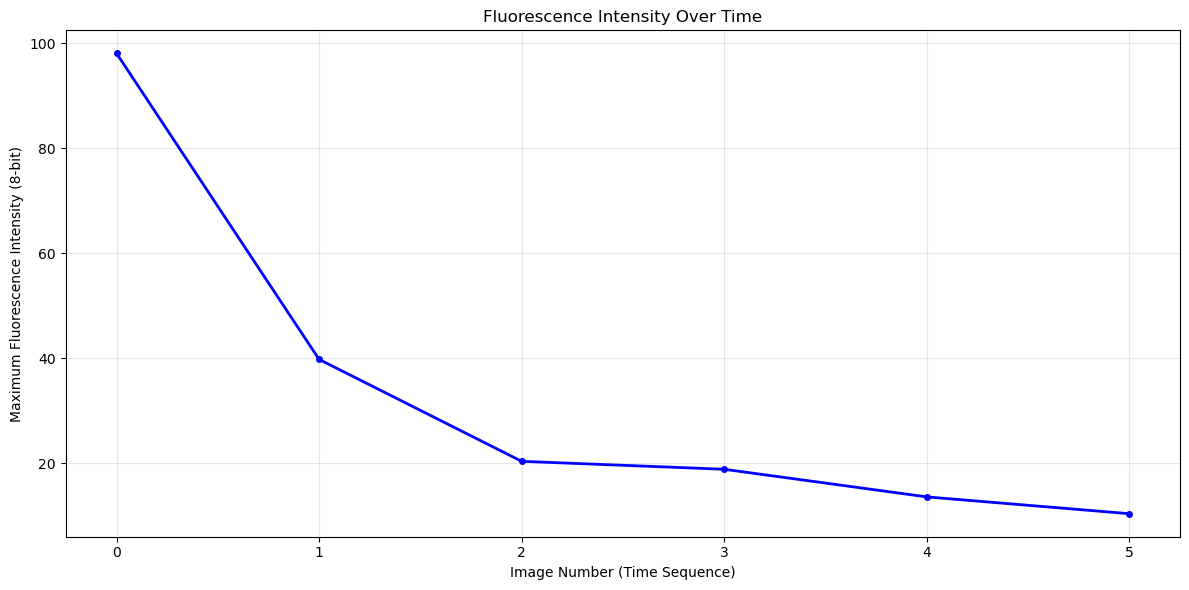

Min: 11.46
Max: 85.82
Range: 74.35


In [99]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(max_list)))

plt.plot(image_numbers, avg_roi_arr, 'b-o', linewidth=2, markersize=4)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

# mean_intensity = np.mean(max_list)
# std_intensity = np.std(max_list)
# plt.axhline(y=mean_intensity, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_intensity:.2f}')
# plt.axhline(y=mean_intensity + std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_intensity + std_intensity:.2f}')
# plt.axhline(y=mean_intensity - std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_intensity - std_intensity:.2f}')

# plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
# print(f"\nFluorescence Intensity Statistics:")
# print(f"Mean: {mean_intensity:.2f}")
# print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min: {min(max_list):.2f}")
print(f"Max: {max(max_list):.2f}")
print(f"Range: {max(max_list) - min(max_list):.2f}")